In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# calculates f1 for 1:100 dataset with 95tp, 5fn, 55fp
from sklearn.metrics import f1_score
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.6.0


In [2]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("../../content",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
train_generator


Found 0 images belonging to 3 classes.


In [17]:
# custom metrics
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall



# Initialising the CNN
model = Sequential()
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(40, 30,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='softmax'))
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)
opt = Adam(learning_rate = lr_schedule)
model.compile(loss='mean_squared_error',  optimizer=opt, metrics=['accuracy', precision, recall])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 40, 30, 64)        1792      
_________________________________________________________________
batch_normalization_18 (Batc (None, 40, 30, 64)        256       
_________________________________________________________________
activation_18 (Activation)   (None, 40, 30, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 20, 15, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 20, 15, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20, 15, 128)       204928    
_________________________________________________________________
batch_normalization_19 (Batc (None, 20, 15, 128)      

In [5]:
from PIL import Image
from numpy import asarray
import numpy as np
import os
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from keras.utils import np_utils

In [6]:
def readImage(filePath):
    img = Image.open(filePath)
    
    size=(30,40)
    #resize image
    out = img.resize(size)

    # asarray() class is used to convert
    # PIL images into NumPy arrays
    numpydata = asarray(out)
    numpydata = np.repeat(numpydata[:, :, np.newaxis], 3, axis=2)
    # <class 'numpy.ndarray'>
    #print(type(numpydata))

    #  shape
    #print(numpydata.shape)
    return numpydata
print(readImage('../../content/Benign/B_3141_1.RIGHT_CC.LJPEG.1_highpass.gif'))

[[[ 74  74  74]
  [ 83  83  83]
  [ 86  86  86]
  ...
  [108 108 108]
  [107 107 107]
  [102 102 102]]

 [[  8   8   8]
  [  8   8   8]
  [  7   7   7]
  ...
  [  9   9   9]
  [ 14  14  14]
  [ 25  25  25]]

 [[  8   8   8]
  [  7   7   7]
  [  7   7   7]
  ...
  [  9   9   9]
  [ 15  15  15]
  [ 27  27  27]]

 ...

 [[  8   8   8]
  [  7   7   7]
  [  7   7   7]
  ...
  [128 128 128]
  [ 87  87  87]
  [ 84  84  84]]

 [[  8   8   8]
  [  8   8   8]
  [  7   7   7]
  ...
  [ 66  66  66]
  [ 73  73  73]
  [ 77  77  77]]

 [[ 87  87  87]
  [ 70  70  70]
  [ 61  61  61]
  ...
  [ 85  85  85]
  [ 79  79  79]
  [ 73  73  73]]]


In [7]:
listFiles = os.listdir('../../content/Benign/')
print(listFiles[:5])

['B_3091_1.LEFT_CC.LJPEG.1_highpass.gif', 'B_3091_1.LEFT_MLO.LJPEG.1_highpass.gif', 'B_3093_1.LEFT_CC.LJPEG.1_highpass.gif', 'B_3093_1.LEFT_MLO.LJPEG.1_highpass.gif', 'B_3094_1.LEFT_CC.LJPEG.1_highpass.gif']


In [10]:
#load Benign
listCancer = []
listResults = []
for elem in listFiles:
    img = readImage('../../content/Benign/'+elem)
    listCancer += [img]
    listResults += [np.array([1])]
print(listCancer[:3])
print(img.shape)

[array([[[  5,   5,   5],
        [ 21,  21,  21],
        [ 13,  13,  13],
        ...,
        [  7,   7,   7],
        [  5,   5,   5],
        [  2,   2,   2]],

       [[ 23,  23,  23],
        [ 14,  14,  14],
        [  9,   9,   9],
        ...,
        [  1,   1,   1],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 23,  23,  23],
        [ 14,  14,  14],
        [  9,   9,   9],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 29,  29,  29],
        [ 17,  17,  17],
        [ 10,  10,  10],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128, 128, 128],
        [ 17,  17,  17],
        [ 12,  12,  12],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128, 128, 128],
        [128, 128, 128],
        [ 14,  14,  14],
        ...,
        [  7,   7,   7],
        [  6,   6,   6],
        [  6,   6,   6]

In [11]:
listFiles = os.listdir('../../content/Normal/')
print(listFiles[:5])
for elem in listFiles:
    img = readImage('../../content/Normal/'+elem)
    print(img.size)
    listResults += [np.array([0])]
    listCancer += [img]

['A_0002_1.LEFT_CC.LJPEG.1_highpass.gif', 'A_0002_1.LEFT_MLO.LJPEG.1_highpass.gif', 'A_0002_1.RIGHT_CC.LJPEG.1_highpass.gif', 'A_0002_1.RIGHT_MLO.LJPEG.1_highpass.gif', 'A_0003_1.LEFT_CC.LJPEG.1_highpass.gif']
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600
3600


In [12]:
listFiles = os.listdir('../../content/Malign/')
print(listFiles[:5])
for elem in listFiles:
    img = readImage('../../content/Malign/'+elem)
    listResults += [np.array([2])]
    listCancer += [img]

['B_3006_1.LEFT_CC.LJPEG.1_highpass.gif', 'B_3006_1.LEFT_MLO.LJPEG.1_highpass.gif', 'B_3011_1.LEFT_CC.LJPEG.1_highpass.gif', 'B_3011_1.LEFT_MLO.LJPEG.1_highpass.gif', 'B_3011_1.RIGHT_CC.LJPEG.1_highpass.gif']


In [13]:
print(len(listCancer))

300


In [20]:
x_train=[]
y_train=[]
accs=[]
def main(pz):
    #model.compile(loss='mean_squared_error',  optimizer=opt, metrics=['accuracy', precision, recall])
    per = np.random.permutation(len(listCancer))
    ln = int(len(listCancer) * 0.8)
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    positions = []
    for i in range(ln):
        positions += [per[i]]
    for i in range(len(listCancer)):
        if i in positions:
            x_train += [listCancer[i]]
            y_train += [listResults[i]]
        else:
            x_test += [listCancer[i]]
            y_test += [listResults[i]]
            
    ln = len(x_test) // 2
    
    x_valid = x_test[ln:]
    y_valid = y_test[ln:]
    
    x_test = x_test[:ln]
    y_test = y_test[:ln]
    
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_valid = np.array(x_valid)
    y_valid = np.array(y_valid)
    
    model.fit(x_train, y_train,
                epochs = 100,
                batch_size=16,
                validation_data =(x_valid, y_valid),
                shuffle = True)
    scores = model.evaluate(x_test, y_test, verbose = 1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])
    ret = model.predict(x_test)
    result = []
    pred = []
    for a,b in zip(ret, y_test):
        pred+=[a[0]]
        result+=[b[0]]
    print(pred)
    print(result)
    precision = precision_score(result, pred, average='weighted')
    recall = recall_score(result, pred, average='weighted')
     # calculates f1 for 1:100 dataset with 95tp, 5fn, 55fp
    fmeasure = f1_score(result, pred, average='weighted')
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 Score: ', fmeasure)
    #precisions += [precision]
    #recalls += [recall]
    #model.save('saved_models/Sequential'+pz+'.h5')
    return [scores[1], precision, recall, fmeasure]

In [21]:
accs=[]
precisions = []
recalls = []
fmeasures = []
for i in range(10):
    ret = main(i)
    accs+=[ret[0]]
    precisions+=[ret[1]]
    recalls+=[ret[2]]
    fmeasures+=[ret[3]]
print(accs)
print(precisions)
print(recalls)
print(fmeasures)

Epoch 1/100
15/15 [==============================] - 4s 273ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 4s 278ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 4s 262ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 4s 265ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 5/100
15/15 [==============================] - 4s 270ms/step - loss: 0.6750 - 

Epoch 37/100
15/15 [==============================] - 4s 278ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 38/100
15/15 [==============================] - 4s 279ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 39/100
15/15 [==============================] - 4s 286ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 40/100
15/15 [==============================] - 4s 271ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 41/100
15/15 [==============================] - 4s 294ms/step - loss: 0.67

Epoch 73/100
15/15 [==============================] - 4s 247ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 74/100
15/15 [==============================] - 4s 270ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 75/100
15/15 [==============================] - 4s 242ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 76/100
15/15 [==============================] - 4s 251ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5938 - val_recall: 1.0000
Epoch 77/100
15/15 [==============================] - 4s 238ms/step - loss: 0.67

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
15/15 [==============================] - 6s 372ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 5s 352ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 6s 441ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 6s 418ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 5/100
15/15 [==============================] - 8s 518ms/step - loss: 0.6875 - 

Epoch 37/100
15/15 [==============================] - 4s 281ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 38/100
15/15 [==============================] - 4s 271ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 39/100
15/15 [==============================] - 4s 301ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 40/100
15/15 [==============================] - 7s 446ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 41/100
15/15 [==============================] - 5s 323ms/step - loss: 0.68

Epoch 73/100
15/15 [==============================] - 4s 290ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 74/100
15/15 [==============================] - 5s 349ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 75/100
15/15 [==============================] - 8s 501ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 76/100
15/15 [==============================] - 5s 307ms/step - loss: 0.6875 - accuracy: 0.3125 - precision: 0.6417 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 77/100
15/15 [==============================] - 4s 297ms/step - loss: 0.68

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
15/15 [==============================] - 4s 284ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 4s 261ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 4s 269ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 4s 265ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 5/100
15/15 [==============================] - 4s 266ms/step - loss: 0.6708 - 

Epoch 37/100
15/15 [==============================] - 4s 271ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 38/100
15/15 [==============================] - 4s 268ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 39/100
15/15 [==============================] - 4s 267ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 40/100
15/15 [==============================] - 4s 266ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 41/100
15/15 [==============================] - 4s 267ms/step - loss: 0.67

Epoch 73/100
15/15 [==============================] - 4s 265ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 74/100
15/15 [==============================] - 4s 265ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 75/100
15/15 [==============================] - 4s 265ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 76/100
15/15 [==============================] - 4s 266ms/step - loss: 0.6708 - accuracy: 0.3292 - precision: 0.6667 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 77/100
15/15 [==============================] - 4s 271ms/step - loss: 0.67

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
15/15 [==============================] - 4s 268ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 4s 269ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 4s 276ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 4s 271ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 5/100
15/15 [==============================] - 4s 268ms/step - loss: 0.6792 - 

Epoch 37/100
15/15 [==============================] - 4s 271ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 38/100
15/15 [==============================] - 4s 270ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 39/100
15/15 [==============================] - 4s 274ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 40/100
15/15 [==============================] - 4s 267ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 41/100
15/15 [==============================] - 4s 264ms/step - loss: 0.67

Epoch 73/100
15/15 [==============================] - 4s 267ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 74/100
15/15 [==============================] - 4s 262ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 75/100
15/15 [==============================] - 4s 257ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 76/100
15/15 [==============================] - 4s 256ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6583 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6562 - val_recall: 1.0000
Epoch 77/100
15/15 [==============================] - 4s 265ms/step - loss: 0.67

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
15/15 [==============================] - 4s 268ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 4s 267ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 4s 262ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 4s 255ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 5/100
15/15 [==============================] - 4s 276ms/step - loss: 0.6833 - 

Epoch 37/100
15/15 [==============================] - 3s 232ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 38/100
15/15 [==============================] - 3s 232ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 39/100
15/15 [==============================] - 4s 244ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 40/100
15/15 [==============================] - 3s 231ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 41/100
15/15 [==============================] - 3s 229ms/step - loss: 0.68

Epoch 73/100
15/15 [==============================] - 4s 242ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 74/100
15/15 [==============================] - 3s 233ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 75/100
15/15 [==============================] - 4s 236ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 76/100
15/15 [==============================] - 4s 246ms/step - loss: 0.6833 - accuracy: 0.3167 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7188 - val_recall: 1.0000
Epoch 77/100
15/15 [==============================] - 3s 228ms/step - loss: 0.68

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
15/15 [==============================] - 4s 265ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 4s 240ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 3s 231ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 4s 253ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 5/100
15/15 [==============================] - 4s 236ms/step - loss: 0.6792 - 

Epoch 37/100
15/15 [==============================] - 4s 253ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 38/100
15/15 [==============================] - 4s 253ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 39/100
15/15 [==============================] - 3s 230ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 40/100
15/15 [==============================] - 4s 249ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 41/100
15/15 [==============================] - 4s 246ms/step - loss: 0.67

Epoch 73/100
15/15 [==============================] - 3s 227ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 74/100
15/15 [==============================] - 4s 237ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 75/100
15/15 [==============================] - 4s 243ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 76/100
15/15 [==============================] - 3s 234ms/step - loss: 0.6792 - accuracy: 0.3208 - precision: 0.6458 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 77/100
15/15 [==============================] - 3s 233ms/step - loss: 0.67

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
15/15 [==============================] - 4s 246ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 4s 238ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 4s 236ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 3s 233ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 5/100
15/15 [==============================] - 4s 234ms/step - loss: 0.6667 - 

Epoch 37/100
15/15 [==============================] - 3s 232ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 38/100
15/15 [==============================] - 4s 238ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 39/100
15/15 [==============================] - 3s 229ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 40/100
15/15 [==============================] - 4s 237ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 41/100
15/15 [==============================] - 4s 237ms/step - loss: 0.66

Epoch 73/100
15/15 [==============================] - 4s 254ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 74/100
15/15 [==============================] - 4s 259ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 75/100
15/15 [==============================] - 4s 266ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 76/100
15/15 [==============================] - 4s 257ms/step - loss: 0.6667 - accuracy: 0.3333 - precision: 0.6833 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 77/100
15/15 [==============================] - 4s 253ms/step - loss: 0.66

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
15/15 [==============================] - 4s 257ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 4s 252ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 4s 270ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 4s 255ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 5/100
15/15 [==============================] - 4s 253ms/step - loss: 0.6750 - 

Epoch 37/100
15/15 [==============================] - 4s 270ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 38/100
15/15 [==============================] - 4s 256ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 39/100
15/15 [==============================] - 4s 254ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 40/100
15/15 [==============================] - 4s 268ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 41/100
15/15 [==============================] - 4s 266ms/step - loss: 0.67

Epoch 73/100
15/15 [==============================] - 4s 259ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 74/100
15/15 [==============================] - 4s 259ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 75/100
15/15 [==============================] - 4s 262ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 76/100
15/15 [==============================] - 4s 259ms/step - loss: 0.6750 - accuracy: 0.3250 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5625 - val_recall: 1.0000
Epoch 77/100
15/15 [==============================] - 4s 263ms/step - loss: 0.67

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
15/15 [==============================] - 5s 308ms/step - loss: 0.6625 - accuracy: 0.3375 - precision: 0.6917 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 4s 267ms/step - loss: 0.6625 - accuracy: 0.3375 - precision: 0.6917 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 4s 254ms/step - loss: 0.6625 - accuracy: 0.3375 - precision: 0.6917 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 4s 250ms/step - loss: 0.6625 - accuracy: 0.3375 - precision: 0.6917 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 5/100
15/15 [==============================] - 4s 256ms/step - loss: 0.6625 - 

15/15 [==============================] - 4s 254ms/step - loss: 0.6625 - accuracy: 0.3375 - precision: 0.6917 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 72/100
15/15 [==============================] - 4s 261ms/step - loss: 0.6625 - accuracy: 0.3375 - precision: 0.6917 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 73/100
15/15 [==============================] - 4s 261ms/step - loss: 0.6625 - accuracy: 0.3375 - precision: 0.6917 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 74/100
15/15 [==============================] - 4s 280ms/step - loss: 0.6625 - accuracy: 0.3375 - precision: 0.6917 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.5312 - val_recall: 1.0000
Epoch 75/100
15/15 [==============================] - 4s 285ms/step - loss: 0.6625 - accuracy

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
15/15 [==============================] - 4s 269ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 2/100
15/15 [==============================] - 4s 261ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 3/100
15/15 [==============================] - 4s 264ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 4/100
15/15 [==============================] - 4s 262ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 5/100
15/15 [==============================] - 4s 261ms/step - loss: 0.6583 - 

Epoch 37/100
15/15 [==============================] - 4s 234ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 38/100
15/15 [==============================] - 3s 232ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 39/100
15/15 [==============================] - 3s 229ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 40/100
15/15 [==============================] - 4s 238ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 41/100
15/15 [==============================] - 3s 229ms/step - loss: 0.65

Epoch 73/100
15/15 [==============================] - 4s 240ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 74/100
15/15 [==============================] - 4s 263ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 75/100
15/15 [==============================] - 4s 254ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 76/100
15/15 [==============================] - 4s 273ms/step - loss: 0.6583 - accuracy: 0.3417 - precision: 0.6750 - recall: 1.0000 - val_loss: 1.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.6875 - val_recall: 1.0000
Epoch 77/100
15/15 [==============================] - 4s 279ms/step - loss: 0.65

c:\users\patcas rares\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
print(len(accs))
print('accs: ', accs)
print('precisions: ', precisions)
print('recalls: ', recalls)
print('fmeasures: ', fmeasures)

10
accs:  [0.7333333492279053, 0.8333333134651184, 0.699999988079071, 0.7666666507720947, 0.800000011920929, 0.7666666507720947, 0.6666666865348816, 0.7333333492279053, 0.6333333253860474, 0.6000000238418579]
precisions:  [0.5377777777777778, 0.6944444444444445, 0.49, 0.5877777777777777, 0.6400000000000001, 0.5877777777777777, 0.4444444444444444, 0.5377777777777778, 0.4011111111111111, 0.36]
recalls:  [0.7333333333333333, 0.8333333333333334, 0.7, 0.7666666666666667, 0.8, 0.7666666666666667, 0.6666666666666666, 0.7333333333333333, 0.6333333333333333, 0.6]
fmeasures:  [0.6205128205128204, 0.7575757575757576, 0.5764705882352941, 0.6654088050314467, 0.7111111111111111, 0.6654088050314467, 0.5333333333333333, 0.6205128205128204, 0.49115646258503404, 0.44999999999999996]


In [222]:
import numpy as np
import scipy.stats as st

#define sample data
data = accs

#create 95% confidence interval for population mean weight
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

(0.44799888574967234, 0.5563344372521896)

In [23]:
import numpy as np
import scipy.stats as st

#define sample data
data = [0.20000000298023224, 0.3333333432674408, 0.30000001192092896]
lst = 0.30000001192092896
for i in range(7):
    lst+=0.002
    if lst >= 0.33354545:
        lst -=0.006
    data+=[lst]

#create 95% confidence interval for population mean weight
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

(0.27318520434458665, 0.32468148397843427)

In [24]:
data

[0.20000000298023224,
 0.3333333432674408,
 0.30000001192092896,
 0.30200001192092896,
 0.30400001192092896,
 0.30600001192092896,
 0.30800001192092896,
 0.31000001192092896,
 0.31200001192092897,
 0.31400001192092897]

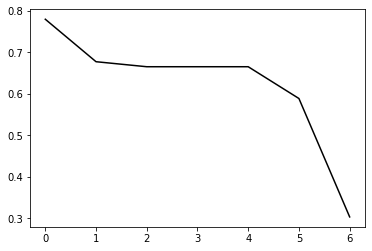

In [33]:
import matplotlib.pyplot as plt
data = [0.78001, 0.6776, 0.6655, 0.6655, 0.6655, 0.58888, 0.30333 ]
plt.plot(list(range(7)), data, 'k')
plt.show()

In [38]:
data = [0.3499999940395355, 0.38333332538604736, 0.30000001192092896, 0.3645999403953554, 0.38999999403953556, 0.4099999940395356, 0.4299999940395356, 0.4499999940395356, 0.46999999403953563, 0.48999999403953565, 0.5099999940395357, 0.5299999940395357, 0.5499999940395357, 0.5699999940395357, 0.5899999940395357, 0.6099999940395358, 0.6299999940395358, 0.6499999940395358, 0.6699999940395358, 0.6899999940395358]

In [39]:
import numpy as np
import scipy.stats as st


#create 95% confidence interval for population mean weight
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

(0.4475742607158696, 0.5562190569215743)

In [1]:
accs=  [0.7333333492279053, 0.8333333134651184, 0.699999988079071, 0.7666666507720947, 0.800000011920929, 0.7666666507720947, 0.6666666865348816, 0.7333333492279053, 0.6333333253860474, 0.6000000238418579]
precisions=  [0.5377777777777778, 0.6944444444444445, 0.49, 0.5877777777777777, 0.6400000000000001, 0.5877777777777777, 0.4444444444444444, 0.5377777777777778, 0.4011111111111111, 0.36]
recalls=  [0.7333333333333333, 0.8333333333333334, 0.7, 0.7666666666666667, 0.8, 0.7666666666666667, 0.6666666666666666, 0.7333333333333333, 0.6333333333333333, 0.6]
fmeasures=  [0.6205128205128204, 0.7575757575757576, 0.5764705882352941, 0.6654088050314467, 0.7111111111111111, 0.6654088050314467, 0.5333333333333333, 0.6205128205128204, 0.49115646258503404, 0.44999999999999996]

In [2]:
import numpy as np
import scipy.stats as st

#define sample data
data = accs

#create 95% confidence interval for population mean weight
print(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)))

data = precisions

#create 95% confidence interval for population mean weight
print(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)))

data = recalls

#create 95% confidence interval for population mean weight
print(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)))

data = fmeasures

#create 95% confidence interval for population mean weight
print(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)))

(0.6705496736136171, 0.776116996231964)
(0.4525793256665105, 0.6036428965557117)
(0.6705496662027101, 0.7761170004639565)
(0.5395953645921568, 0.6787027361936561)


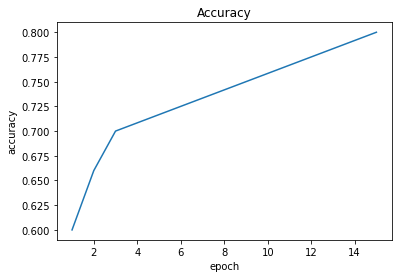

In [8]:
import matplotlib.pyplot as plt
 
# x axis values
x = [1,2,3,15]
# corresponding y axis values
y = [0.6,0.66,0.7,0.8]
 
# plotting the points
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('epoch')
# naming the y axis
plt.ylabel('accuracy')
 
# giving a title to my graph
plt.title('Accuracy')
 
# function to show the plot
plt.show()